In [2]:
#import packages and data
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import random

random.seed(1337)
df = pd.read_csv("winequality-red.csv", delimiter = ';')

def qclass(x):
    if x >= 7:
        return 'above_avg'
    else:
        return 'avg_or_less'

df['quality_class'] = df['quality'].apply(qclass)

df = df.drop('quality', axis=1)
X = df.drop('quality_class', axis=1)
y = df['quality_class']

In [3]:
#func to partition data at a given boundary
def partition(data, feature, boundary):

    true_rows = data[data[feature] >= boundary]
    false_rows = data[data[feature] < boundary]
            
    return true_rows, false_rows

In [4]:
#the gini impurity for calculating the impurity of a node
def gini(data, target):

    counts = data[target].value_counts()
    impurity = 1
    
    for c in counts:
        prob_of_label = c/float(len(data))
        impurity -= prob_of_label**2
        
    return impurity

In [5]:
#the function to calculate information gain from splitting a node
def info_gain(left, right, current_uncertainty, target):

    p = float(len(left))/(len(left)+len(right))
    split_uncertainty = p*gini(left, target) + (1-p)*gini(right, target)
    ig = current_uncertainty - split_uncertainty
    
    return ig

In [6]:
#pick the best feature and boundary combination that produces the highest information gain 
def best_split(data, target):

    best_gain = 0
    best_feature = None
    best_boundary = None
    current_uncertainty = gini(data, target)
    features = data.columns.drop(target)

    for f in features:
        if best_feature == None:
            best_feature = f
            
        boundaries = list(set(data[f]))

        for b in boundaries:
            if best_boundary == None:
                best_boundary = b
                
            tr, fr = partition(data, f, b)
            
            if (len(tr) == 0) or (len(fr) == 0):
                continue

            gain = info_gain(tr, fr, current_uncertainty, target)

            if gain >= best_gain:
                best_gain, best_feature, best_boundary = gain, f, b

    return best_gain, best_feature, best_boundary

In [7]:
#create leaf nodes or branch nodes based on a number of conditions for the current data
def make_node(data, target, split_level, min_leaf, max_depth):
    
    gain, feature, boundary = best_split(data, target)
    node = {
            'info_gain': gain, 
            'size': len(data), 
            'feature': feature, 
            'boundary': boundary
           }
    
    if (gain == 0) or (len(data) <= min_leaf) or (split_level > max_depth):
        node['node_type'] = 'leaf'
        prediction = {}
        counts = data[target].value_counts()
        prediction = 0
        prediction_chance = 0
        for i in counts.index:
            prediction_chance_i = counts[i]/float(len(data))
            if prediction_chance_i > prediction_chance:
                prediction_chance = prediction_chance_i
                prediction = i
        node['prediction'] = prediction
        node['prediction_chance'] = prediction_chance
        
    elif gain > 0:
        node['node_type'] = 'branch'
        
    return node

In [8]:
#generate the performance metrics of a model for a given class
def get_metrics(pred, target='quality_class', positive_class='above_avg'):
    
    correct_preds = pred[pred[target]==pred['predictions']]
    correct = len(correct_preds)
    correct_pos_preds = correct_preds[correct_preds[target]==positive_class]
    correct_positive = len(correct_pos_preds)
    positive_actual = len(pred[pred[target]==positive_class])
    positive_pred = len(pred[pred['predictions']==positive_class])
    total = len(pred)
    acc = correct/total
    precision = correct_positive/positive_pred
    recall = correct_positive/positive_actual
    f1 = 2*precision*recall/(precision+recall)
    print('accuracy:',round(acc, 4),', precision:',round(precision, 4),', recall:',round(recall, 4),', f1:',round(f1, 4))
    
    return acc, precision, recall, f1

In [9]:
#generate the weighted performance metrics of a model
def get_weighted_metrics(pred, target='quality_class'):
    
    precision = {}
    recall = {}
    f1 = {}
    class_n = {}
    total = len(pred)
    
    classes = list(set(pred[target]))
    for c in classes:
        correct_preds = pred[pred[target]==pred['predictions']]
        correct = len(correct_preds)
        correct_pos_preds = correct_preds[correct_preds[target]==c]
        correct_positive = len(correct_pos_preds)
        positive_actual = len(pred[pred[target]==c])
        positive_pred = len(pred[pred['predictions']==c])
        acc = correct/total
        precision[c] = correct_positive/positive_pred
        recall[c] = correct_positive/positive_actual
        f1[c] = 2*precision[c]*recall[c]/(precision[c]+recall[c])
        class_n[c] = positive_actual
    
    w_precision = 0
    w_recall = 0
    w_f1 = 0
    for c in classes:
        w_precision+=(precision[c]*class_n[c]/total)
        w_recall+=(recall[c]*class_n[c]/total)
        w_f1+=(f1[c]*class_n[c]/total)
        
    print('accuracy:',round(acc, 4),', wprecision:',round(w_precision, 4),', wrecall:',round(w_recall, 4),', wf1:',round(w_f1, 4))
    
    return acc, w_precision, w_recall, w_f1

In [10]:
#this is where the magic happens! func to train the decision tree
def dtree(data = {}, decision_tree = {}, 
          split_level = 0, max_depth = 7, min_leaf = 5, 
          target = 'quality_class'):
    
    if split_level == 0:
        root = make_node(data, target, split_level, min_leaf, max_depth)
        root['node_type'] = 'root'
        decision_tree[split_level] = [(data, root)]
        
    decision_tree[split_level + 1] = []
    keep_splitting = 0
    
    
    for d, n in decision_tree[split_level]:
        
        if (n['node_type'] != 'leaf'):
            
            gain, feature, boundary = best_split(d, target)
            tr, fr = partition(d, feature, boundary)

            right_branch = make_node(tr, target, split_level + 1, min_leaf, max_depth)
            n['right_child_feature'] = right_branch['feature']
            n['right_child_boundary'] = right_branch['boundary']
            decision_tree[split_level + 1].append((tr, right_branch))
            if (right_branch['node_type'] == 'branch'):
                keep_splitting = 1

            left_branch = make_node(fr, target, split_level + 1, min_leaf, max_depth)
            n['left_child_feature'] = left_branch['feature']
            n['left_child_boundary'] = left_branch['boundary']
            decision_tree[split_level + 1].append((fr, left_branch))
            if (left_branch['node_type'] == 'branch'):
                keep_splitting = 1
    
    split_level += 1
    
    if (keep_splitting == 1):
        decision_tree, split_level = dtree(decision_tree = decision_tree, split_level = split_level)
        
    return decision_tree, split_level

In [11]:
#func to make predictions based on a trained tree
def dtree_predict(data, tree, target = 'quality_class'):

    predictions = {}
            
    for i in range(len(data)):
        
        x = data.iloc[i]
        
        for s in range(len(tree)):
            
            if (s == 0):
                node = tree[s][0][1]
                current_feature = node['feature']
                current_boundary = node['boundary']
                
            for n in range(len(tree[s])):
                
                node = tree[s][n][1]
                
                if ((node['feature'] == current_feature) and (node['boundary'] == current_boundary)):
                    
                    if (node['node_type']!='leaf'):  
                        
                        if (x[current_feature] >= current_boundary):
                            next_feature = node['right_child_feature']
                            next_boundary = node['right_child_boundary']

                        elif (x[current_feature] < current_boundary):
                            next_feature = node['left_child_feature']
                            next_boundary = node['left_child_boundary']
                            
                    if (node['node_type']=='leaf'):
                        prediction = node['prediction']
        
            current_feature = next_feature
            current_boundary = next_boundary
        
        predictions[i] = prediction
        
    data['predictions'] = pd.Series(predictions)

    return data

In [12]:
#random forest func built upon the previous decision tree func
def rforest_predict(test_data, train_data, target = 'quality_class', n_trees = 69):

    samples = []
    trees = []
    dt_predictions = pd.DataFrame()
    rf_predictions = []
    classes = list(set(test_data[target]))

    for i in range(n_trees):
        sample_size = int(len(train_data)/2)
        sample = train_data.sample(n=sample_size)
        sample = sample.reset_index(drop=True)
        samples.append(sample)

    for s in samples:
        tree, sl = dtree(s, target=target)
        print('tree completed')
        trees.append(tree)

    pred_number = 1
    for t in trees:
        prediction = dtree_predict(test_data, t, target)
        dt_predictions['prediction'+str(pred_number)] = prediction['predictions']
        pred_number+=1

    for i in range(len(dt_predictions)):
        counts = {}

        for c in classes:
            counts[c] = 0

        for col in dt_predictions.columns:
            dt_pred = dt_predictions[col][i]
            counts[dt_pred]+=1

        biggest_count = 0
        for c in counts.keys():
            if counts[c] >= biggest_count:
                biggest_count = counts[c]
                rf_pred = c

        rf_predictions.append(rf_pred)

    test_data['rf_predictions'] = pd.Series(rf_predictions)  
    
    return test_data

In [13]:
#creates a dict where keys are a fold and values are lists containing training and testing data,
#training data for each fold has been undersampled to address class imbalance as well as reduce training runtime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X.copy(), y.copy())

fold = 1
skf_df ={}

for train_index, test_index in skf.split(X, y):
    
    rus = RandomUnderSampler(random_state=42)
    xtr, ytr = rus.fit_resample(X.iloc[train_index], y.iloc[train_index])
    train_df = pd.concat([xtr, ytr], axis=1).reset_index(drop=True)
    test_df = pd.concat([X.iloc[test_index], y.iloc[test_index]], axis=1).reset_index(drop=True)
    skf_df[fold] = [train_df, test_df]
    fold+=1

In [14]:
#cross validate model and return performance metrics for each fold
rf_cv_results_minority = []
rf_cv_results_weighted = []
rfpredslist = []

for fold in skf_df:
    kf_train_df = skf_df[fold][0]
    kf_test_df = skf_df[fold][1]
    
    rfpreds = rforest_predict(test_data=kf_test_df, train_data=kf_train_df, target='quality_class', n_trees=11)
    rfpredslist.append(rfpreds)
    
    fold_results_minority = [get_metrics(pred=rfpreds, target='quality_class', positive_class='above_avg')]
    rf_cv_results_minority.append(fold_results_minority)
    
    fold_results_weighted = [get_weighted_metrics(pred=rfpreds, target='quality_class')]
    rf_cv_results_weighted.append(fold_results_weighted)

tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
accuracy: 0.8063 , precision: 0.2727 , recall: 0.2857 , f1: 0.2791
accuracy: 0.8063 , wprecision: 0.8101 , wrecall: 0.8063 , wf1: 0.8082
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
accuracy: 0.8187 , precision: 0.3824 , recall: 0.619 , f1: 0.4727
accuracy: 0.8187 , wprecision: 0.8638 , wrecall: 0.8188 , wf1: 0.8357
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
accuracy: 0.475 , precision: 0.1961 , recall: 0.9091 , f1: 0.3226
accuracy: 0.475 , wprecision: 0.8597 , wrecall: 0.475 , wf1: 0.5372
tree completed
tree completed
tree completed
tree completed
tree completed
tree completed
tree com

In [16]:
#find mean and std for each performance metric across k folds
import numpy as np

a = rf_cv_results_minority
b = np.asarray(a)
c = np.mean(b, axis=1)
d = pd.DataFrame(c)
e = d.rename(columns = {0:'accuracy', 1:'precision', 2:'recall', 3:'f1'})
avg_metrics = e.mean(axis=0)
avg_metrics.name = 'mean_scores'
std_metrics = e.std(axis=0)
std_metrics.name = 'std_of_scores'

print(avg_metrics)
print(std_metrics)

accuracy     0.702905
precision    0.268065
recall       0.649134
f1           0.367415
Name: mean_scores, dtype: float64
accuracy     0.099752
precision    0.070409
recall       0.244655
f1           0.096292
Name: std_of_scores, dtype: float64


##RESULTS OF PREVIOUS RUN##

accuracy     0.684642
precision    0.281667
recall       0.659524
f1           0.378611
Name: mean_scores, dtype: float64

accuracy     0.138242
precision    0.112642
recall       0.203107
f1           0.120722
Name: std_of_scores, dtype: float64

In [17]:
#confusion matrix and classification report generated for reporting
#also, prediction and target data are binarized in preparation for PR curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

bin_labels = {'above_avg': 1, 'avg_or_less': 0}

allrfpred = pd.concat(rfpredslist, ignore_index=True)

print(confusion_matrix(allrfpred['quality_class'], allrfpred['predictions']))
print(classification_report(allrfpred['quality_class'], allrfpred['predictions']))

allrfpred = allrfpred.replace(bin_labels)

[[141  76]
 [399 983]]
              precision    recall  f1-score   support

   above_avg       0.26      0.65      0.37       217
 avg_or_less       0.93      0.71      0.81      1382

    accuracy                           0.70      1599
   macro avg       0.59      0.68      0.59      1599
weighted avg       0.84      0.70      0.75      1599



In [18]:
#plot PR curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import style

#style.use('dark_background')

gary_precision, gary_recall, gary_thresholds = precision_recall_curve(allrfpred['quality_class'], allrfpred['predictions'])


In [15]:
#!/usr/bin/env python
# coding: utf-8

# In[196]:


#import os
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler


# In[4]:


#os.chdir('C:\\Users\\An-94\\desktop\\ucr\\CS235\\project')


# In[5]:


red_wine = pd.read_csv("winequality-red-undelimited-preprocessed_2.csv", 
                           usecols = ['fixed acidity','volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'above_average'])

#red_wine['above_average'] = red_wine['above_average'].apply(str)


# In[6]:


red_wine.head(5)


# In[ ]:


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.20)

rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)


# In[ ]:





# In[7]:


def partition(data, feature, boundary): #create a function the partition's data based on where it falls on the boundary condition
    left = data[data[feature] >= boundary ]
    right = data[data[feature] < boundary ]
    
    return left, right


# In[9]:


def gini(data, target): #the gini impurity for calculating the impurity of parent, and child nodes

    counts = data[target].value_counts()
    impurity = 1
    
    for c in counts:
        prob_of_label = c/float(len(data))
        impurity -= prob_of_label**2
        
    return impurity


# In[10]:


def info_gain(left, right, current_uncertainty, target): #the function to calculate information gain

    p = float(len(left))/(len(left)+len(right))
    split_uncertainty = p*gini(left, target) + (1-p)*gini(right, target)
    ig = current_uncertainty - split_uncertainty
    
    return ig


# In[11]:


def best_split(data, target): #pick the best feature and boundary combination that produces the highest information gain 
    #initialize the best gain, feature, and boundary variables
    best_gain = 0
    best_feature = None
    best_boundary = None
    current_uncertainty = gini(data, target)
    features = data.columns.drop(target)

    for f in features: #interate over features
        if best_feature == None:
            best_feature = f
            
        boundaries = list(set(data[f]))

        for b in boundaries: #interate over boundaries
            if best_boundary == None:
                best_boundary = b
                
            tr, fr = partition(data, f, b) #output the true rows and false rows at feature and boundary combination
            
            if (len(tr) == 0) or (len(fr) == 0): #if there are no true rows or false rows continue
                continue

            gain = info_gain(tr, fr, current_uncertainty, target) #fnd the information gain at the current impurity level

            if gain >= best_gain: 
                #if the current information gain is greater than the best gain then make that the new best gain(along with
                #its feature and boundary)
                best_gain, best_feature, best_boundary = gain, f, b

    return best_gain, best_feature, best_boundary


# In[12]:


def make_node(data, target, split_level, min_leaf, max_depth): 
    #create leaf nodes or decision nodes based on whether there was information gain
    
    gain, feature, boundary = best_split(data, target)
    node = {
            'info_gain': gain, 
            'size': len(data), 
            'feature': feature, 
            'boundary': boundary
           }
    # create a node variable with keys info_gain, size, feature, and boundary
    
    if (gain == 0) or (len(data) <= min_leaf) or (split_level > max_depth):
        node['node_type'] = 'leaf' #if all conditions are met then create a node type called leaf
        prediction = {} #create a dictionary called prediction
        counts = data[target].value_counts() #get he counts of the classes
        prediction = 0 
        prediction_chance = 0
        for i in counts.index: #for rows in the counts index which consists of two classes
            prediction_chance_i = counts[i]/float(len(data)) #find the general probability of the class at that index
            if prediction_chance_i > prediction_chance: #if the general prob is greater than the current prob 
                prediction_chance = prediction_chance_i #assign the new prob to prediction chance
                prediction = i #and make row equal to the prediction
        node['prediction'] = prediction #after that assign the prediction row class to column prediction
        node['prediction_chance'] = prediction_chance #and assign the new probability to the prediction chance column 
        
    elif gain > 0:
        node['node_type'] = 'branch' #if the information gain is greater than zero then create a node type called a branch
        
    return node


# In[106]:


def dtree(data = {}, decision_tree = {}, 
          split_level = 0, max_depth = 8, min_leaf = 5, 
          target = 'above_average'):
    
    if split_level == 0: #if the depth is at the root node than continue
        root = make_node(data, target, split_level, min_leaf, max_depth) #create a node and set it to the root variable
        root['node_type'] = 'root' #create a column in root variable called 'node type' and assign string 'root' to it
        decision_tree[split_level] = [(data, root)] 
        #the decision tree is a dictionary whever every level consists of data and node; the data is the partitioned data for
        #each node
        
    decision_tree[split_level + 1] = [] #add 1 to the split level after assignment of data and node to the root
    keep_splitting = 0 
    
    
    for d, n in decision_tree[split_level]:#d is the interator for the data and n is the interator for the nodes
        
        if (n['node_type'] != 'leaf'): #if the node is not a leaf it is a decision node
            
            gain, feature, boundary = best_split(d, target) #assign the best gain, feature and boundary at best split
            tr, fr = partition(d, feature, boundary) #assign true rows and false rows at that split

            right_branch = make_node(tr, target, split_level + 1, min_leaf, max_depth) #create the right branch of the tree with
            #true rows and add one to split level
            n['right_child_feature'] = right_branch['feature'] #for the node create a column right child feature and assign
            # the feature variable for the right branches
            n['right_child_boundary'] = right_branch['boundary'] #for the node create a column right child boundary and assign
            # the boundary condition for the right branches
            decision_tree[split_level + 1].append((tr, right_branch)) #append to the decision tree the true rows and the right
            #branch and add one to the split level
            if (right_branch['node_type'] == 'branch'): #if the node type is a right branch keep splitting
                keep_splitting = 1 

            left_branch = make_node(fr, target, split_level + 1, min_leaf, max_depth) 
            n['left_child_feature'] = left_branch['feature']
            n['left_child_boundary'] = left_branch['boundary']
            decision_tree[split_level + 1].append((fr, left_branch)) #do the same things but for the left branch which is for 
            #the false rows
            if (left_branch['node_type'] == 'branch'): #if the node is a left branch keep splitting
                keep_splitting = 1
    
    split_level += 1 #after the left branches and right branches are created move to the next depth level
    #print('tree level', split_level, 'complete')
    
    if (keep_splitting == 1): #a recursive function that output the results of the decision tree at each split level
        decision_tree, split_level = dtree(decision_tree = decision_tree, split_level = split_level)
        
    return decision_tree, split_level


# In[22]:


node = dtree(red_wine)


# In[46]:


#node[0][0] root node
#node[0][1] 2 branches 2 nodes
node[0][2] #4 branches 4 nodes


# In[100]:


def dtree_predict(data, tree, target = 'above_average'):
    
    predictions = {}
    
    for i in range(len(data)): #iterate over the length of the data
        
        x = data.iloc[i] #assign the data at each i row to x
        
        for s in range(len(tree)): #interate over the split levels of the tree dictionary
            
            if (s == 0): #if the level is at the root node
                node = tree[s][0][1]
                # the first index represent the whole tree, the second represent the # of branches of the tree, and the last 
                #represents a single node at the split level in a branch
                current_feature = node['feature'] #set the current feature and boundary
                current_boundary = node['boundary']
                
            for n in range(len(tree[s])): #for node in each length split levels
                
                node = tree[s][n][1]
                
                if ((node['feature'] == current_feature) and (node['boundary'] == current_boundary)):
                    
                    if (node['node_type']!='leaf'):  #if the node is not a leaf 
                        
                        if (x[current_feature] >= current_boundary): 
                        #if the row in the current feature is greater than the boundary, append the features and boundaries
                        #from the right child feature and boundary columns
                            next_feature = node['right_child_feature']
                            next_boundary = node['right_child_boundary']

                        elif (x[current_feature] < current_boundary): #if the row is less append the features and boundaries
                        #from the left child
                            next_feature = node['left_child_feature']
                            next_boundary = node['left_child_boundary'] 
                            
                    if (node['node_type']=='leaf'):
                        prediction = node['prediction'] #if the node type is a leaf make a prediction
        
            current_feature = next_feature #when the loop is done advance to the next level and 
            current_boundary = next_boundary
        
    predictions[i] = prediction
    data['predictions'] = pd.Series(predictions) #assign the prediction at the instance to the predictions column in the dataframe

    return data


# In[48]:


def get_metrics(pred, target='above_average', positive_class= 1):

    correct_preds = pred[pred['above_average']==pred['predictions']] #true positive or true negative
    correct = len(correct_preds) # # of correct predictions
    correct_pos_preds = correct_preds[correct_preds['above_average']== 1] #true positives
    correct_positive = len(correct_pos_preds) # # of true positives
    positive_actual = len(pred[pred['above_average']== 1]) #counts where real value is positive
    positive_pred = len(pred[pred['predictions']== 1]) #counts where predicted value is positive

    total = len(pred) #total number of predictions
    acc = correct/total #percent of predictions that were correct

    precision = correct_positive / positive_pred #percentage of how often a classifier is right about the prediction
    recall = correct_positive/positive_actual #percentage of how often a classifier successfully predict the real value
    f1 = 2*precision*recall/(precision+recall) #harmonic mean of precision and recall
    print('accuracy:',round(acc, 4),', precision:',round(precision, 4),', recall:',round(recall, 4),', f1:',round(f1, 4))
    
    return acc, precision, recall, f1


# In[194]:


def confusionator(pred, target='above_average'):
    
    cm = {}
    classes = list(set(pred[target]))
    correct_preds = pred[pred[target]==pred['predictions']]
    incorrect_preds = pred[pred[target]!=pred['predictions']]
    for c in classes:
        cm['# correct for actual class: '+str(c)] = len(correct_preds[correct_preds[target]==c])
        cm['# incorrect for actual class: '+str(c)] = len(incorrect_preds[incorrect_preds[target]==c])
        
    return cm


# In[101]:


x = red_wine.loc[:,red_wine.columns != "above_average"]
y = red_wine["above_average"]


# In[102]:


from sklearn.model_selection import StratifiedKFold # import KFold

skf = StratifiedKFold(n_splits=10) 
skf.get_n_splits(x.copy(), y.copy()) # returns the number of splitting iterations in the cross-validator
print(skf)


# In[229]:


from sklearn.model_selection import StratifiedKFold  # import KFold

fold = 1
skf_df = {} 

skf = StratifiedKFold(n_splits=10) 
skf.get_n_splits(x.copy(), y.copy())

for train_index, test_index in skf.split(x, y):

    rus = RandomUnderSampler(random_state=42)

    x_train, y_train = rus.fit_resample(x.iloc[train_index], y.iloc[train_index])

    train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
    
    test_df = pd.concat([x.iloc[test_index], y.iloc[test_index]], axis=1).reset_index(drop=True)
    skf_df[fold] = [train_df, test_df]
    fold += 1
#skf_df[fold #][0=train, 1=test]


# In[237]:


dt_cv_results_minority = [] #initilize the lists the will be result of the cross validation
#dt_cv_results_weighted = []
tpreds_list = []

for fold in skf_df: #iterate over folds in the dictionary skf_df in which the indexes of the x and y cols and train and testsets are stored
    kf_train_df = skf_df[fold][0] #iterated over the selected train dataframes and assign to a variable
    kf_test_df = skf_df[fold][1] #iterated over the selected test dataframes and assign to a variable
    
    dt, sl = dtree(data=kf_train_df, target='above_average') #put the training dataset into the tree function
    tpred = dtree_predict(kf_test_df, dt, target = 'above_average') #take the prediction results and compare with test_data
    tpreds_list.append(tpred)
    
    fold_results_minority = [get_metrics(pred=tpred, target='above_average', positive_class= 1)]
    dt_cv_results_minority.append(fold_results_minority)
    
    #fold_results_weighted = [get_weighted_metrics(pred= tpred, target='above_average')]
    #dt_cv_results_weighted.append(fold_results_weighted)


# In[238]:


tpreds_list


# In[239]:


tpreds_folded = pd.concat(tpreds_list, ignore_index = True)
tpreds_folded


# In[225]:


a = dt_cv_results_minority
b = np.asarray(a)
c = np.mean(b, axis = 1)


d = pd.DataFrame(c)
d

per_report_df = d.rename(columns={ 0 : "accuracy",  1 : "precision",  2 : "recall", 3 : "f1"})
per_report_mean  = e.mean(axis = 0)
print(e)
print(f)


# In[226]:


per_report_df


# In[227]:


per_report_mean 


# In[228]:


per_report_stdev = e.std(axis = 0)
per_report_stdev


# In[195]:


cm = confusionator(tpred)
cm


# In[222]:


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix(tpred['above_average'], tpred['predictions'])


# In[224]:



print(classification_report(tpred['above_average'], tpred['predictions']))


# In[240]:


tpreds_folded = pd.concat(tpreds_list, ignore_index = True)
tpreds_folded


# In[ ]:


#plot a precision recall curve 


# In[246]:


import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from matplotlib import style

style.use('default')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
style.use('default')

tn_precision, tn_recall, tn_thresholds = precision_recall_curve(tpreds_folded['above_average'], tpreds_folded['predictions'])
#plt.figure(figsize=(12, 7))
#plt.plot(tn_recall, tn_precision)
#plt.xlabel('Recall (Positive Label: above_avg)', fontsize=8)
#plt.ylabel('Precision (Positive Label: above_avg)', fontsize=8)
#ticks = [.25, .5, .75, 1.00]
#plt.xticks(ticks, ticks, fontsize=8)
#plt.yticks(ticks, ticks, fontsize=8)
#plt.savefig('precision_recall_curve_tn.png')



FileNotFoundError: [Errno 2] No such file or directory: 'winequality-red-undelimited-preprocessed_2.csv'

In [19]:
class naivebayes:
    
    def __init__(self):
        self.var_mean = {}
        self.prob_c = {}
        self.attribute_probabilities = []
        self.t = None
    
    #X and y inputs must be pandas dataframe or numpy arrays    
    def fit(self,X,y, mle = True, priors = [], t = None):
        import numpy as np
        labels = np.unique(y)
        self.t = t
        #estimate class priors with the option to use predefined priors
        if priors == []:
            probabilities_of_c = [float(sum(c == y))/len(y) for c in labels]
        else:
            probabilities_of_c = priors
        #append class probabilities into predefined dictionary
        for n,label in enumerate(labels):
            self.prob_c[label] = probabilities_of_c[n]
        
                   
        #variance and mean for each attribute in a class
        for label in labels:
            self.var_mean[label] = []
            matching = X[np.where(y == label)]
            for i in range(len(matching[0])):
                # m is the "coefficient" for the maximum likelihood estimation of variance
                if mle == True:
                    m = (len(matching.take(i,1)) - 1 )/ len(matching.take(i,1))
                else:
                    m = 1
                var = np.var(matching.take(i,1), ddof = 1) * m
                mean = np.mean(matching.take(i,1))
                self.var_mean[label].append([var,mean])       
                
    #Predicts labels given a set of vectors, either numpy arrays or pandas series
    def gauss_predict(self, vectors):
        import numpy as np
        self.attribute_probabilities = []
        
        #calculate datapoints' probability given a label of class c
        labels = []
        for i in self.prob_c.keys():
            attribute_probability = []
            for n in range(len(vectors[0])):
                var = self.var_mean[i][n][0]
                mean = self.var_mean[i][n][1]
                #I split up the calculation below so that it was tidier/easier to read
                coefficient = 1.0 / ((2.0*np.pi*var)**0.5)
                gauss = lambda x:coefficient * (np.e**(-((x - mean)**2.0)/(2.0*var)))
                #applies the gaussian probability to each datapoint in an attribute
                ap = [gauss(d) for d in vectors.take(n,1)]
                attribute_probability.append(ap)
            #finds the product of all conditionally independent probabilities
            attribute_probability = np.prod(attribute_probability,axis = 0)
            #multiplies each probability by the class prior probability
            attribute_probability = attribute_probability * self.prob_c[i]
            self.attribute_probabilities.append(attribute_probability)
        attribute_probabilities = np.array(self.attribute_probabilities)
        #Prediction 
        classes = [i for i in self.prob_c.keys()]
        if self.t is None:
            for i in range(len(attribute_probabilities[0])):
                if attribute_probabilities[0][i] > attribute_probabilities[1][i]:
                    labels.append(classes[0])
                if attribute_probabilities[0][i] < attribute_probabilities[1][i]:
                    labels.append(classes[1])
            return labels 
        else:
            for i in range(len(attribute_probabilities[0])):
            #this was added for ease of thresholding
                total_prob = sum(attribute_probabilities.take(i,1))
                normalized_ap = attribute_probabilities.take(i,1)/total_prob
            #determine label
                biggest_prob = max(normalized_ap)
                label = int(np.where(attribute_probabilities == max(attribute_probabilities.take(i,1)))[0][0])
            #thresholding
                if biggest_prob < self.t and label == 0: 
                    labels.append(1)    
                else:
                    labels.append(classes[label])
            return labels 
    
    #shows the probabilities for each class for each datapoint
    def predict_proba(self, vectors):
        import numpy as np
        self.gauss_predict(vectors)
        attribute_probabilities = np.array(self.attribute_probabilities)
        normalized_ap = []
        for i in range(len(attribute_probabilities[0])):
            total_prob = sum(attribute_probabilities.take(i,1))
            normalized_ap.append(attribute_probabilities.take(i,1)/total_prob)
        probs = np.array([[i[0],i[1]] for i in normalized_ap])
        return probs
    

In [23]:
import pandas as pd
df = pd.read_csv('winequality-red.csv', delimiter = ';')
q = lambda x:1 if x>= 7 else 0
df['binary_quality'] = df['quality'].apply(q)
data = df[[ 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'sulphates']]
labels = df['binary_quality']
#choice_data = df[['volatile acidity', 'citric acid', 'residual sugar',
 #                 'free sulfur dioxide','total sulfur dioxide', 'pH', 'sulphates']]
from sklearn.preprocessing import scale, StandardScaler
#scaler = StandardScaler()
scaled_data = scale(data, axis = 0)
#scaled_data = scaler.fit_transform(choice_data)



import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
nb = naivebayes()
sk = GaussianNB()
features = ['volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
        'sulphates', 'alcohol']
d = df[features]
X = scale(d, axis = 0)
y = df['binary_quality']
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,
    random_state=119)
myp = []
myr = []
mya = []
skp = []
skr = []
ska = []
avgp = []
avgr = []
avga = []
skavgp = []
skavgr = []
skavga = []
prob_error = []
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    nb.fit(X_train,y_train)
    sk.fit(X_train,y_train)
    y_pred = nb.gauss_predict(X_test)
    sky_pred = sk.predict(X_test)
    avg_error = sum(nb.predict_proba(X_test).take(1,1) - sk.predict_proba(X_test).take(1,1)) / len(nb.predict_proba(X_test).take(1,1))
    prob_error.append(avg_error)
    myp.append(precision_score(y_test, y_pred))
    myr.append(recall_score(y_test, y_pred))
    mya.append(accuracy_score(y_test, y_pred))
    skp.append(precision_score(y_test, sky_pred))
    skr.append(recall_score(y_test, sky_pred))
    ska.append(accuracy_score(y_test, sky_pred))



    


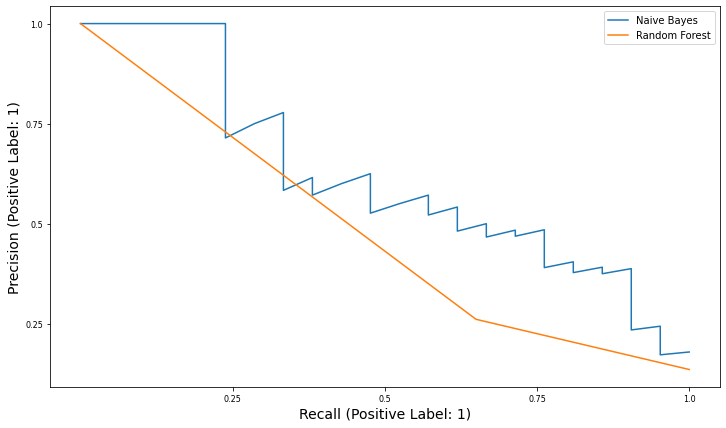

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
p = nb.predict_proba(X_test)
#check = [i[1] for i in p]
precision, recall, thresholds = precision_recall_curve(y_test, p.take(1,1))
plt.figure(figsize = (12,7))
plt.plot(recall,precision)
plt.plot(gary_recall, gary_precision)
#plt.plot(tn_recall, tn_precision)
plt.xlabel('Recall (Positive Label: 1)', fontsize = 14)
plt.ylabel('Precision (Positive Label: 1)', fontsize = 14)
ticks = [0.25,0.5,0.75,1.0]
plt.xticks(ticks,ticks, fontsize = 8)
plt.yticks(ticks,ticks, fontsize = 8)
plt.legend(['Naive Bayes', 'Random Forest'])
plt.savefig('precision_recall_curve_group.png')

In [31]:
gary_precision

array([0.13570982, 0.26111111, 1.        ])